In [7]:
import ipynb.fs.full.quick_functions as xyz
import plotly.graph_objects as go

variable = "MEXCPALTT01CTGYM"
df = xyz.get_fred(variable,20)
df.index = pd.to_datetime(df.index)
#df = df.pct_change(1).iloc[1:] #only necessary to convert index to monthly

df.head()

,MEXCPALTT01CTGYM
DATE,
2003-11-01,3.982120
2003-12-01,3.976522
2004-01-01,4.201510
2004-02-01,4.534443
2004-03-01,4.230729


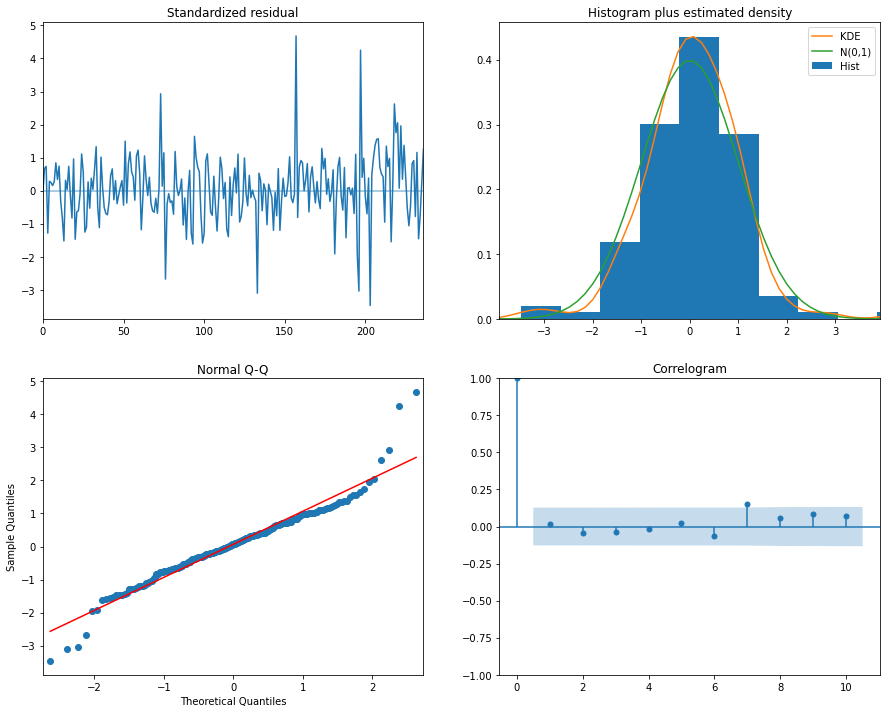

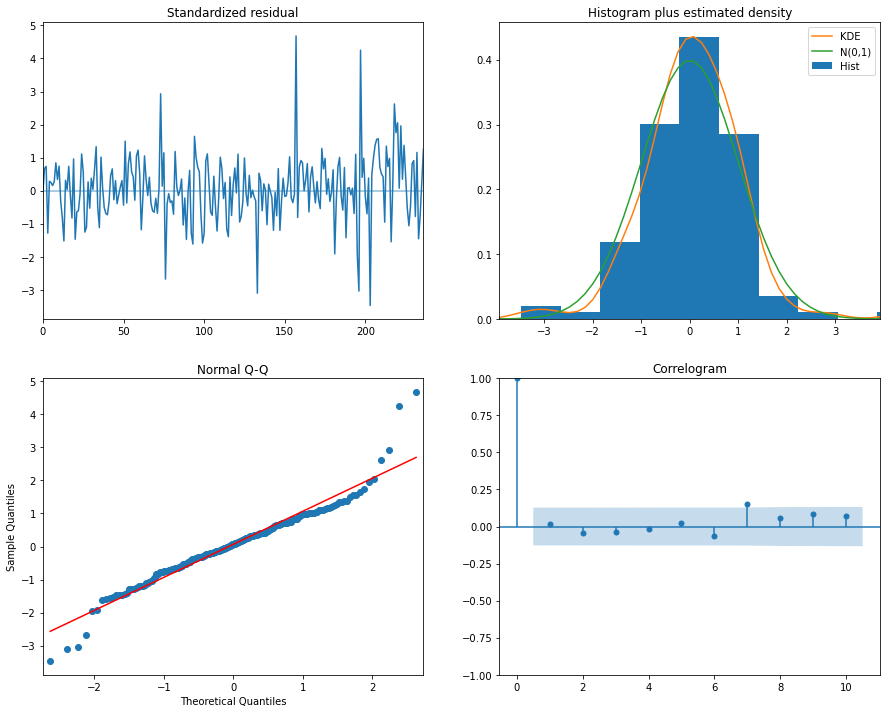

In [8]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

from statsmodels.tsa.stattools import adfuller
!pip install pmdarima --quiet
import pmdarima as pm

currency = variable

#Standard ARIMA Model
ARIMA_model = pm.auto_arima(df[currency], 
                      start_p=1, 
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=True, # No Seasonality for standard ARIMA
                      trace=False, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)

ARIMA_model.plot_diagnostics(figsize=(15,12))

In [9]:
def forecast(ARIMA_model, periods=24):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df.index, y=df[currency], mode='lines', name=currency, line=dict(color='#1f76b4')))
    fig.add_trace(go.Scatter(x=fitted_series.index, y=fitted_series, mode='lines', name='Fitted', line=dict(color='red')))
    fig.add_trace(go.Scatter(x=lower_series.index, y=lower_series, fill=None, mode='lines', line=dict(color='lightblue')))
    fig.add_trace(go.Scatter(x=upper_series.index, y=upper_series, fill='tonexty', mode='lines', line=dict(color='lightblue'), name='Prediction Interval'))

    # Layout settings
    fig.update_layout(
        title=f"ARIMA/SARIMA - Forecast of {currency}",
        xaxis_title="Date",
        yaxis_title="Value",
        showlegend=True,
        template='simple_white'  # You can change the template to match your preferences
    )

    fig.show()

forecast(ARIMA_model)